In [1]:
%load_ext autoreload
%autoreload 2

In [394]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA, NMF

In [327]:
# global plotting params
plt.style.use('ggplot')
# gg plot colors are nice but want seaborn style
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

sns.set()
sns.set_style('white')
params = {'legend.fontsize': 'xx-large',
          'text.usetex':False,
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

plt.rc("axes.spines", top=False, right=False) # despine

plt.rcParams.update(params)

In [272]:
import popoff
from average_traces import AverageTraces, SingleCells
from Session import Session, SessionLite

In [273]:
dff = AverageTraces('dff')
dff.build_trace_dict()
session = dff.sessions[2]

In [387]:
def trial_PCs(flu, remove_artifact):
    
    flu = flu[:, :, remove_artifact]
    prepost_border = np.where(~remove_artifact)[0][0]
    
    # Yeah dont do this its gross
    global PCs_subbed
    PCs_subbed = []
    
    global PCs_full
    PCs_full = []
    
    for trial_idx in range(flu.shape[1]):
        
        trial = flu[:, trial_idx, :]
        
        # Max number of components allowed, -1 so dont get 
        # confused by the square matrix
        model = PCA(n_components=min(trial.shape)-1)
        
        model.fit(trial)
        
        # [n_components x n_frames]
        components = model.components_
        n_components_include = 1
        components = components[np.arange(n_components_include), :]
        
        # What feature of the PCs do we want to return??
        # Not sure, start with the pre/post
        pre = components[:, :prepost_border]
        post = components[:, prepost_border:]
        subbed = np.mean(post, 1) - np.mean(pre, 1)
        
        PCs_subbed.append(subbed)
        PCs_full.append(components)

#         PCs.append(np.mean(components, 1))

        
    
    PCs_subbed = np.array(PCs_subbed)
    PCs_full = np.array(PCs_full)
    return np.array(PCs)

In [388]:
x = prepare_data(session, model='partial')

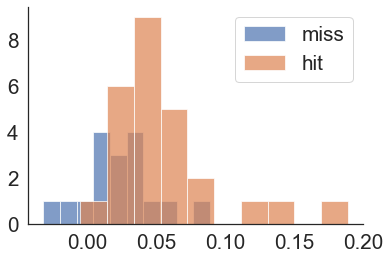

In [389]:
plt.hist(PCs_subbed[y==0, 0], alpha=0.7, label='miss')
plt.hist(PCs_subbed[y==1, 0], alpha=0.7, label='hit')
plt.legend()

In [390]:
def prepare_data(session, frames='all', model='full'):
    
    ''' Prepare fluoresence data in Session object for regression

    Arugments:
    session - Session object to get data from
    frames - Which trial frames (relative to photostim) to return? ['pre', 'post', 'all']

    Returns:
    X - data matrix for use as independent variable [n_samples x n_features]
    y - vector for use as dependent variable [n_samples]

    TODO: Currently X is average activity on each test trial for every cell
       y is hit/miss. Expand function to have the option of multiple different
       variables.

    '''
         
    # Fluoresence array were are interested in [n_cells x n_trials x n_frames]
    flu = session.behaviour_trials
    # session.frames_use is used to match imaging rates across sessions
    flu = flu[:, :, session.frames_use]
    
    # Just select test trials
    trial_bool = session.photostim==1
    flu = flu[:, trial_bool, :]
    
    # Decode hit vs miss 
    global y
    y = session.decision
    y = y[trial_bool]
    
    # Make sure binary classification
    assert len(set(y)) == 2
    
    # Currently the independent variables are the mean activity across the whole trial
    # for every cell
    
    # Split the trace into pre=frames-before-stim and post=frames-after-stim
    pre = dff.times_use < 0
    post = dff.times_use > 0.6
    remove_artifact = np.logical_or(pre, post)
    
    if model == 'full':
    
        if frames == 'pre':
            flu = flu[:, :, pre]
        elif frames == 'post':
            flu = flu[:, :, post]
        elif frames == 'all':
            flu = flu[:, :, remove_artifact]
        else:
            raise ValueError('Valid frames are ["pre", "post", "all"]')
    
        X = np.mean(flu, 2)
        
    else:
        # Mean population activity on every trial
        x1 = np.mean(flu, (0,2))
        
        subbed = np.mean(flu[:, :, post], 2) - np.mean(flu[:, :, pre], 2)
        x2 = np.mean(subbed, 0)
        
        global PCs
        PCs = trial_PCs(flu, remove_artifact)
        x3 = PCs.T
        
        X = np.vstack((x1,x2,x3))
#         X = np.vstack((x1,x2))
        
    # Get input matrix to (n_samples, n_features)
    X = X.T
    # Demean and scale to unit varience
    scaler = sklearn.preprocessing.StandardScaler()
    X = scaler.fit_transform(X)
    
    return X, y

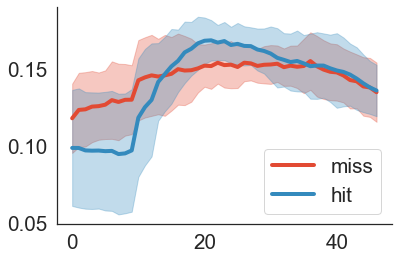

In [393]:
pc_plot = 0

for idx, tt in enumerate(['miss', 'hit']):
    
    trials = PCs_full[y==idx, :, :]
    mean = np.mean(trials[:, pc_plot,:], 0)
    std = np.std(trials[:, pc_plot,:], 0)
    plt.plot(mean, color=colors[idx], label=tt, linewidth=4)
    plt.fill_between(np.arange(len(mean)), mean-std, mean+std, color=colors[idx], alpha=0.3)
    
plt.legend()

In [380]:
def logistic_regression(X, y, penalty, reg_strength, solver, n_folds=5):
    
    results = []
    models = []

    folds = sklearn.model_selection.StratifiedKFold(n_splits=n_folds)
    
    for train_idx, test_idx in folds.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = sklearn.linear_model.LogisticRegression(penalty=penalty, C=reg_strength, class_weight='balanced',
                                                        solver=solver)
        model.fit(X=X_train, y=y_train)

        models.append(model)
        results.append(model.score(X_test, y_test))
    
    return np.mean(results), np.std(results), models

In [381]:
def performance_vs_reg(X, y, penalty, solvers):
    
    reg_strengths = np.linspace(1e-5, 1, 25)
    
    colors = ['red', 'blue', 'green', 'black', 'grey']
    
    for idx, solver in enumerate(solvers):
        
        means = [] 
        stds = [] 

        for reg_strength in reg_strengths:
            
            # Plotting performance as a function of regularisation strength
            # when there is no regularisation doesnt make sense, but it is 
            # the easiest way to eyeball the plots
            if penalty == 'none':
                reg_strength = 0

            mean_acc, std_acc, _ = logistic_regression(X, y, penalty, reg_strength, solver)
            means.append(mean_acc)
            stds.append(std_acc)

        means = np.array(means)
        stds = np.array(stds)
        sems = stds / 5
        plt.plot(reg_strengths, means, label=solver, color=colors[idx])
        plt.fill_between(reg_strengths, means-sems, means+sems, color=colors[idx], alpha=0.3)
        plt.axhline(0.5, linestyle=':')
    
    plt.legend()
    plt.title(penalty.upper())
    plt.ylim(0.35, 1)
    plt.xlabel('Regularisation Strength')
    plt.ylabel('Classifier Performance')
    

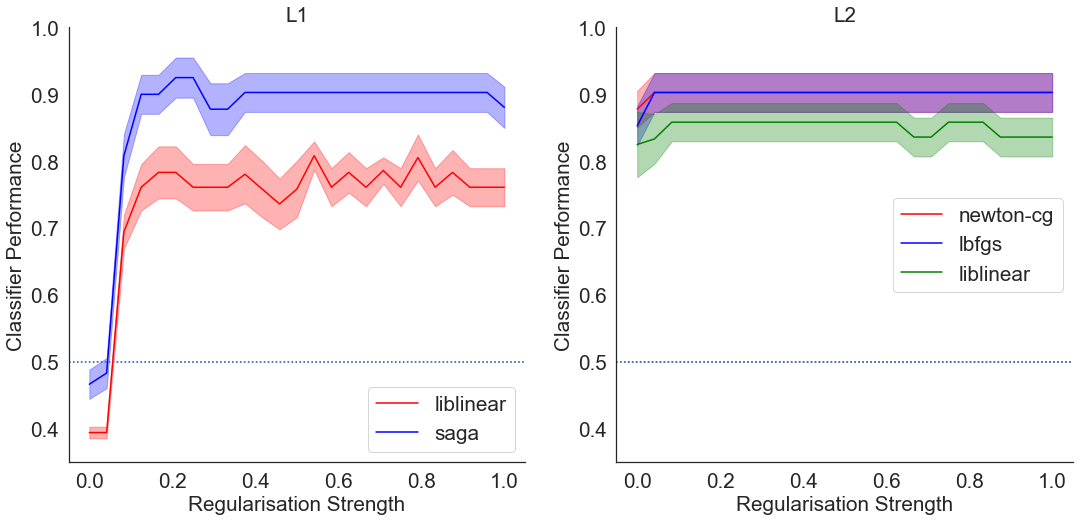

In [433]:
plt.figure(figsize=(18,8))

X, y = prepare_data(session, 'all', 'full')

solvers_dict = {
    #'none': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'l1': ['liblinear', 'saga'],
    #'l2': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    'l2': ['newton-cg', 'lbfgs', 'liblinear']
}

n_plots = 0

for penalty, solvers in solvers_dict.items():
    n_plots += 1
    plt.subplot(1, len(solvers_dict), n_plots)
    
    performance_vs_reg(X, y, penalty, solvers)
    

In [451]:
cc, std_acc, models = logistic_regression(X, y, 'l1', 0.5, 'saga')
coef = np.squeeze(models[0].coef_)

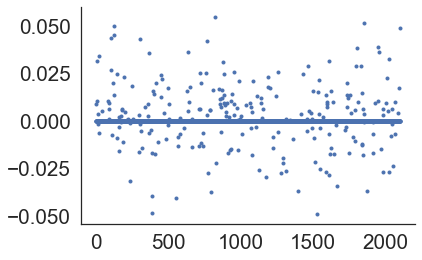

In [452]:
plt.plot(coef, '.')

In [453]:
sum(coef==0) / len(coef)

0.8833888624464541

In [404]:
def var_explained(data, model, plot=False):
 
    X = data - np.min(data)
    model.fit(X)
    varexp = np.cumsum(model.explained_variance_ratio_)

    if plot:
        plt.plot(varexp, label="dff")
        plt.legend()
        plt.xlabel("Num. of components")
        plt.ylabel("Variance explained")
    else:
        return varexp

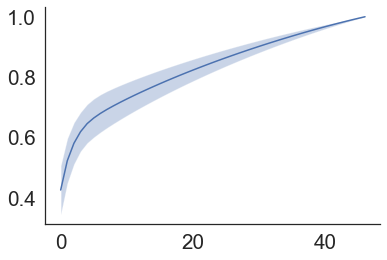

In [405]:
flu = session.behaviour_trials[:, :, session.frames_use]

# Split the trace into pre=frames-before-stim and post=frames-after-stim
pre = dff.times_use < 0
post = dff.times_use > 0.6
remove_artifact = np.logical_or(pre, post)

flu = flu[:, :, remove_artifact]

varexps = []
for trial_idx in range(flu.shape[1]):
    trial = flu[:, trial_idx, :]
    varexps.append(var_explained(trial, PCA(n_components=47)))
    

varexps = np.array(varexps)
mean = np.mean(varexps, 0)
std = np.std(varexps, 0)
plt.plot(mean)
plt.fill_between(np.arange(len(mean)), mean-std, mean+std, alpha=0.3)